In [1]:
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
img = cv2.imread('/home/wroscoe/code/ceres/notebooks/field.png')

In [3]:
def norm_image(img):
    return (img - img.mean() / np.std(img))/255.0

norm_img = norm_image(img)

In [99]:
import random

def get_row(source_img, size=80, max_offset=20):
    """
    Given an source image return a two partial images and 
    their x,y offset from one another.
    """
    
    source_x = source_img.shape[1]
    source_y = source_img.shape[0]
    
    x_offset = random.randint(-max_offset, max_offset)
    y_offset = random.randint(-max_offset, max_offset)
    
    min_x = max(0, 0-x_offset)
    min_y = max(0, 0-y_offset)
    max_x = min(source_x-size, source_x-size-x_offset)
    max_y = min(source_y-size, source_y-size-y_offset)
    
    img_x = random.randint(min_x, max_x)
    img_y = random.randint(min_y, max_y)
    
    #print('min_x: {}  min_y:{}, max_x:{}, max_y:{}'.format(min_x, min_y, max_x, max_y))
    #print('img_x: {}  img_y:{}'.format(img_x, img_y))
    #print('x_offset: {}  y_offset:{}'.format(x_offset, y_offset))
    
    img = source_img[img_y:img_y+size, img_x:img_x+size]
    
    img_offset = source_img[img_y+y_offset:img_y+size+y_offset,
                            img_x+x_offset:img_x+size+x_offset]
    
    
    return img, img_offset, x_offset, y_offset

In [100]:

#helper function to show several images
def show_imgs(img_arr, cmap=None):
    
    fig, ax = plt.subplots(1, img_arr.shape[0], figsize=(15, 6),
                             subplot_kw={'adjustable': 'box-forced'})

    axoff = np.vectorize(lambda ax:ax.axis('off'))
    axoff(ax)

    for i, img in enumerate(img_arr):
        ax[i].imshow(img, cmap=cmap)

In [106]:
for i in range(1000):
    img, img_offset, x_offset, y_offset = get_row(norm_img, size=100, max_offset=20)
    
    if img_offset.shape != (100,100,3):
        print(img_offset.shape)
    

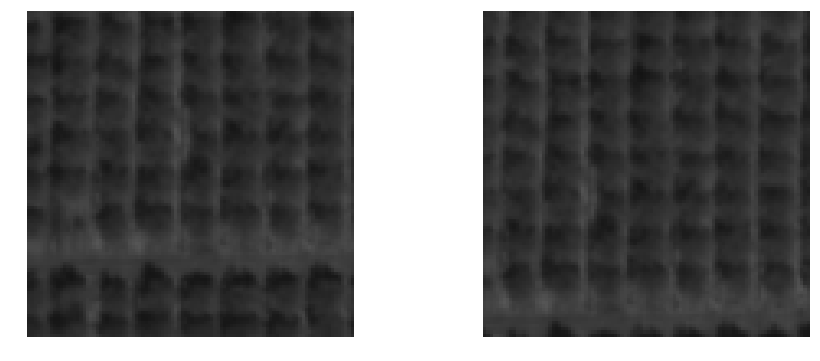

In [107]:
img, img_offset, x_offset, y_offset = get_row(norm_img, size=100, max_offset=20)
imgs = np.array([img, img_offset])
show_imgs(imgs)

In [110]:
def gen_batch(source_img, img_size=80, max_offset=20, batch_size=32):
    while True:
        imgs = []
        imgs_offset=[]
        offsets = []
        for i in range(batch_size):
            results = get_row(source_img,size=img_size, max_offset=max_offset)
            img, img_offset, x_offset, y_offset = results 
            imgs.append(img)
            imgs_offset.append(img_offset)
            offsets.append((x_offset, y_offset))

        X = [np.array(imgs), np.array(imgs_offset)]
        Y = np.array(offsets)

        yield X, Y

In [112]:
gen  = gen_batch(norm_img)
X, Y = next(gen)
print(X[0].shape)
print(X[1].shape)
print(Y.shape)

(32, 80, 80, 3)
(32, 80, 80, 3)
(32, 2)


In [122]:
import keras
from keras.models import Model
from keras.layers import Input, Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import merge

img = Input(shape=(80, 80,3), name='img')



#create convolution layers
x = Convolution2D(8, (3,3), strides=(1,1), activation='relu')(img)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Convolution2D(16, (3,3), strides=(1,1), activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Convolution2D(32, (3,3), strides=(1,1), activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Convolution2D(32, (3,3), strides=(1,1), activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Flatten(name='flattened')(x)

#create convolution layers

img_offset = Input(shape=(80, 80,3), name='img_offset')

y = Convolution2D(8, (3,3), strides=(1,1), activation='relu')(img_offset)
y = MaxPooling2D(pool_size=(2,2))(y)

y = Convolution2D(16, (3,3), strides=(1,1), activation='relu')(y)
y = MaxPooling2D(pool_size=(2,2))(y)

y = Convolution2D(32, (3,3), strides=(1,1), activation='relu')(y)
y = MaxPooling2D(pool_size=(2,2))(y)

y = Convolution2D(32, (3,3), strides=(1,1), activation='relu')(y)
y = MaxPooling2D(pool_size=(2,2))(y)

y = Flatten(name='flattened_offset')(y)


z = keras.layers.Concatenate(axis=1)([x,y])


#create dense layers
z = Dense(32, activation='relu')(z)
z = Dropout(.2)(z)

#continous output of throttle
offsets = Dense(2, activation='relu', name='offsets')(z)

model = Model(inputs=[img, img_offset], outputs=[offsets])

#define loss function that weights angle loss more than throttle loss
model.compile(optimizer='adam',
              loss={'offsets': 'mean_squared_error'},
              loss_weights={'offsets': 1.0})

In [123]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
img (InputLayer)                 (None, 80, 80, 3)     0                                            
____________________________________________________________________________________________________
img_offset (InputLayer)          (None, 80, 80, 3)     0                                            
____________________________________________________________________________________________________
conv2d_98 (Conv2D)               (None, 78, 78, 8)     224                                          
____________________________________________________________________________________________________
conv2d_102 (Conv2D)              (None, 78, 78, 8)     224                                          
___________________________________________________________________________________________

In [124]:
X[1].shape

(32, 80, 80, 3)

In [125]:
model.fit_generator(generator=gen, steps_per_epoch=100, epochs=2)

Epoch 1/2
100/100 [==============================] - 27s - loss: 142.5233    
Epoch 2/2
100/100 [==============================] - 49s - loss: 137.3324    


In [ ]:
model.fit_generator(generator=gen, steps_per_epoch=100, epochs=2)

Epoch 1/2
 23/100 [=====>........................] - ETA: 64s - loss: 139.5306